In [94]:
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
super_classes = ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']

num_classes = len(classes)
num_super_classes = len(super_classes)

In [95]:
import tensorflow as tf

ds_train_fine, ds_test_fine = tf.keras.datasets.cifar100.load_data(label_mode='fine')
ds_train_coarse, ds_test_coarse = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

ds_train = ds_train_coarse[0], ds_train_coarse[1], ds_train_fine[1]
ds_test = ds_test_coarse[0], ds_test_coarse[1], ds_test_fine[1]

ds_train = tf.data.Dataset.from_tensor_slices(ds_train)
ds_test = tf.data.Dataset.from_tensor_slices(ds_test)

for elem in ds_train.take(1):
  print(elem)

(<tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [195, 205, 193],
        [212, 224, 204],
        [182, 194, 167]],

       [[255, 255, 255],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [170, 176, 150],
        [161, 168, 130],
        [146, 154, 113]],

       [[255, 255, 255],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [189, 199, 169],
        [166, 178, 130],
        [121, 133,  87]],

       ...,

       [[148, 185,  79],
        [142, 182,  57],
        [140, 179,  60],
        ...,
        [ 30,  17,   1],
        [ 65,  62,  15],
        [ 76,  77,  20]],

       [[122, 157,  66],
        [120, 155,  58],
        [126, 160,  71],
        ...,
        [ 22,  16,   3],
        [ 97, 112,  56],
        [141, 161,  87]],

       [[ 87, 122,  41],
        [ 88, 122,  39],
        [101, 134,  56],
        ...,
        [ 34,  36,  10

En el siguiente bloque de código, se realiza un análisis detallado de las dimensiones del dataset y de sus elementos. Este proceso es fundamental para comprender la estructura de los datos de entrada y garantizar una manipulación adecuada durante el desarrollo del proyecto de inteligencia artificial.

In [96]:
num_train = len(ds_train)
num_test = len(ds_test)
print(f'Train dataset size: {num_train}')
print(f'Test dataset size: {num_test}')

train_image_spec, train_coarse_spec, train_fine_spec = ds_train.element_spec
test_image_spec, test_coarse_spec, test_fine_spec = ds_train.element_spec

print(f'Train elements shape: {train_image_spec.shape}, {train_coarse_spec.shape}, {train_fine_spec.shape}')
print(f'Test elements shape: {test_image_spec.shape}, {test_coarse_spec.shape}, {train_fine_spec.shape}')

print(f'Train elements type: {train_image_spec.dtype}, {train_coarse_spec.dtype}, {train_fine_spec.shape}')
print(f'Test elements type: {test_image_spec.dtype}, {test_coarse_spec.dtype}, {test_fine_spec.shape}')

Train dataset size: 50000
Test dataset size: 10000
Train elements shape: (32, 32, 3), (1,), (1,)
Test elements shape: (32, 32, 3), (1,), (1,)
Train elements type: <dtype: 'uint8'>, <dtype: 'int64'>, (1,)
Test elements type: <dtype: 'uint8'>, <dtype: 'int64'>, (1,)


Nos fijamos que en los datasets resultantes las imágenes tienen un formato adecuado de 32x32 pixels en 3 canales (RGB), pero las etiquetas deberían ser escalares. Convertimos las etiquetas para que tengan dimensión ().

In [97]:
# Las etiquetas son tensores de dimensión (1,) convertimos a ()
def reshape_label(image, coarse, fine):
  return image, tf.reshape(coarse, ()), tf.reshape(fine, ())

ds_train = ds_train.map(reshape_label)
ds_test = ds_test.map(reshape_label)

Vamos a dividir las clases de imágenes para tener 20 datasets que contengan superclasses.

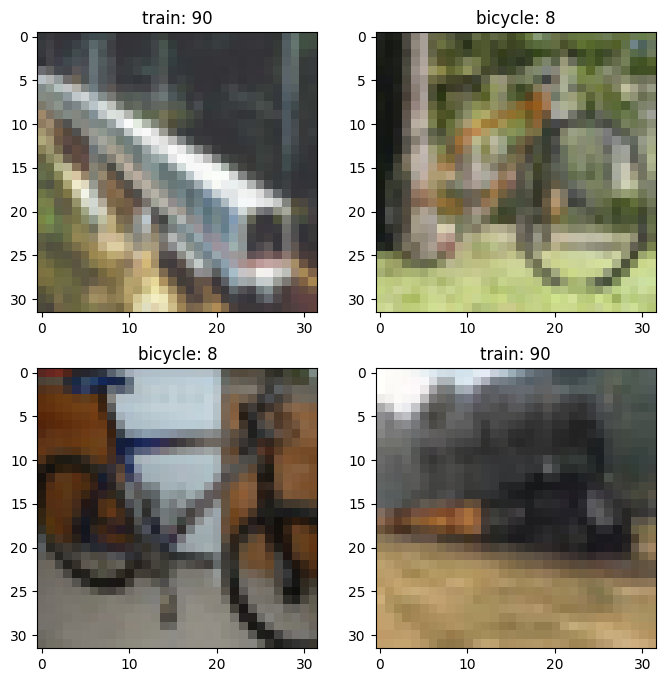

In [98]:
import matplotlib.pyplot as plt
def filter_superclass(image, coarse, fine, target):
  return tf.math.equal(coarse, target)

def remove_coarse(image, coarse, fine):
  return image, fine

ds_groups = [[], []]
for i, ds in enumerate((ds_train, ds_test)):
  for j in range(len(super_classes)):
    target = j
    filtered_dataset = ds.filter(lambda image, coarse, fine: filter_superclass(image, coarse, fine, target))
    filtered_dataset = filtered_dataset.map(remove_coarse)
    ds_groups[i].append(filtered_dataset)


fig = plt.figure(figsize=(8, 8))
# Mostramos 4 imágenes del dataset de entrenamiento
for i, x in enumerate(ds_groups[0][18].take(4)):
  image, label = x
  plt.subplot(2, 2, i+1)
  plt.imshow(image)
  plt.title(f"{classes[label]}: {label}")

A continuación podemos echar un vistazo a 4 imágenes del dataset y comprobar que las etiquetas se adecuan a su imagen asociada.

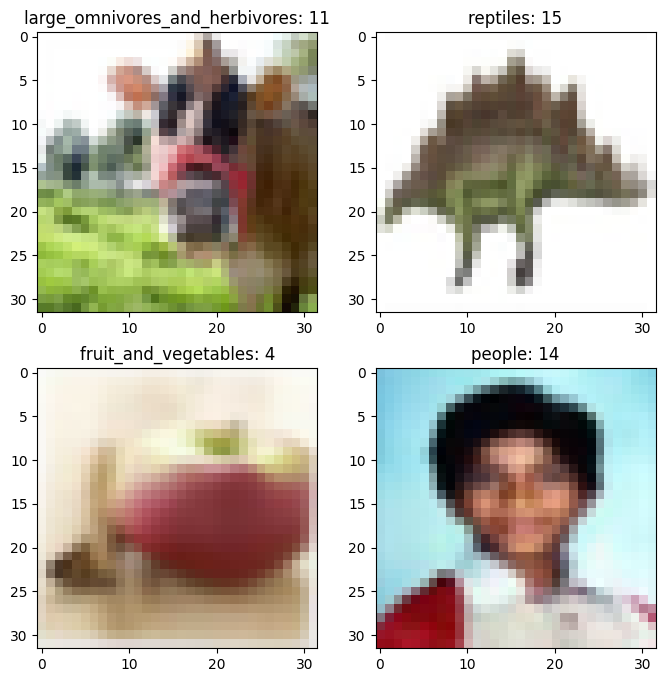

In [99]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
# Mostramos 4 imágenes del dataset de entrenamiento
for i, x in enumerate(ds_train.take(4)):
  image, coarse, _ = x
  plt.subplot(2, 2, i+1)
  plt.imshow(image)
  plt.title(f"{super_classes[coarse]}: {coarse}")

Todo parece correcto, realizamos ahora, un preprocesamiento de las imágenes y etiquetas, para convertirlas en inputs adecuados para nuestros modelos. Definimos la función preprocessing, que aplicaremos a los elementos de los dataset de entrenamiento y test.

In [100]:
def remove_fine(image, coarse, fine):
  return image, coarse

ds_train = ds_train.map(remove_fine)
ds_test = ds_test.map(remove_fine)

def preprocessing(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  label = tf.one_hot(label, depth=num_super_classes)
  return image, label

ds_train = ds_train.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

Vemos que la normalización ha tenido éxito

In [101]:
for elem in ds_train.take(1):
  print(elem)

(<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.7647059 , 0.8039216 , 0.75686276],
        [0.83137256, 0.8784314 , 0.8       ],
        [0.7137255 , 0.7607843 , 0.654902  ]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.6666667 , 0.6901961 , 0.5882353 ],
        [0.6313726 , 0.65882355, 0.50980395],
        [0.57254905, 0.6039216 , 0.44313726]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [1.        , 1.        , 1.        ],
        ...,
        [0.7411765 , 0.78039217, 0.6627451 ],
        [0.6509804 , 0.69803923, 0.50980395],
        [0.4745098 , 0.52156866, 0.34117648]],

       ...,

       [[0.5803922 , 0.7254902 , 0.30980393],
        [0.556

Definimos como datos de validación parte de los datos de entrenamiento, contamos con 50_000 muestras utilizaremos un 20% para validación (10_000 imágenes para validación y 40_000 para ajustar los pesos durante cada época)

In [102]:
ratio = 0.2
validation_size = int(ratio * num_train) # 10_000
base_ds_val = ds_train.take(validation_size)
base_ds_fit = ds_train.skip(validation_size)

len(base_ds_val), len(base_ds_fit)

(10000, 40000)

Los inputs a la red serán lotes de 64 imágenes del dataset para ajuste ds_fit.\
Utilizamos .cache() para guardar en caché las transformaciones realizadas con .map(), usamos .shuffle() y .batch() para mezclar los elementos antes de formar los lotes, consiguiendo así lotes únicos para cada época. Finalmente con .prefetch() especificamos que el siguientes lotes se carguen de manera paralela mientras se entrena una época.

In [103]:
batch_size = 128 # multiplo de 32
ds_fit = base_ds_fit.cache()
ds_fit = ds_fit.shuffle(buffer_size=len(ds_fit))
ds_fit = ds_fit.batch(batch_size)
ds_fit = ds_fit.prefetch(tf.data.experimental.AUTOTUNE)

Para el dataset de validación ds_val, no mezclamos ya que no influye en los ajustes de pesos. Aunque si que tendrá influencia el detener las épocas en función de los datos de validación.

In [104]:
batch_size = 128
ds_val = base_ds_val.cache()
ds_val = ds_val.batch(batch_size)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

Preparamos el learning rate adaptativo a usar en el callback

In [105]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Define a function to adjust the learning rate
def lr_schedule(epoch):
    if epoch < 15:
        return 0.01  # First 5 epochs
    elif epoch < 30:
        return 0.001  # Next 5 epochs
    elif epoch < 45:
        return 0.0005
    else:
        return 0.0001  # Rest of the epochs

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)


# Define your callbacks
callbacks = [early_stopping, lr_scheduler, reduce_lr]

Añadimos un random flip y rotación a las imágenes (data augmentation)

In [106]:
"""import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

# Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])"""



'import matplotlib.pyplot as plt\nimport numpy as np\nimport tensorflow as tf\nimport tensorflow_datasets as tfds\n\nfrom tensorflow.keras import layers\n\n# Define the data augmentation layer\ndata_augmentation = tf.keras.Sequential([\n    layers.RandomFlip("horizontal_and_vertical"),\n    layers.RandomRotation(0.2),\n])'

Como queremos obtener los mismos resultados para cualquier usuario que ejecute el programa, usamos una seed para inicializar los pesos posteriormente.

In [107]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

Arquitectura de la red

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ZeroPadding2D
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
# Specify the regularization strength
l2_reg_strength = 0.01

# Build the model
model = Sequential([

    preprocessing.RandomFlip("horizontal",input_shape=(32, 32, 3)),
    preprocessing.RandomBrightness(factor=0.2),
    preprocessing.RandomZoom(.5, .2),
    # Añadir una capa de ZeroPadding2D antes de la primera capa convolucional
    ZeroPadding2D(padding=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg_strength)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg_strength)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg_strength)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg_strength)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg_strength)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_super_classes, activation='softmax')
])




# Hacemos una copia del modelo, con los mismos pesos y la misma arquitectura
model_test = tf.keras.models.clone_model(model)


# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo utilizando el conjunto de datos
history = model.fit(ds_fit, epochs=60, validation_data=ds_val, callbacks=callbacks)

last_epoch = len(history.history['val_loss'])

Epoch 1/60
313/313 [==============================] - 18s 36ms/step - loss: 7.0414 - accuracy: 0.2668 - val_loss: 5.0277 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 2/60
313/313 [==============================] - 9s 30ms/step - loss: 3.2818 - accuracy: 0.3775 - val_loss: 3.7300 - val_accuracy: 0.2257 - lr: 0.0010
Epoch 3/60
313/313 [==============================] - 9s 28ms/step - loss: 2.7907 - accuracy: 0.4242 - val_loss: 2.9839 - val_accuracy: 0.3399 - lr: 0.0010
Epoch 4/60
313/313 [==============================] - 9s 29ms/step - loss: 2.6285 - accuracy: 0.4514 - val_loss: 3.0379 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 5/60
313/313 [==============================] - 9s 29ms/step - loss: 2.5629 - accuracy: 0.4662 - val_loss: 2.7008 - val_accuracy: 0.4254 - lr: 0.0010
Epoch 6/60
313/313 [==============================] - 9s 28ms/step - loss: 2.5338 - accuracy: 0.4807 - val_loss: 2.8313 - val_accuracy: 0.4021 - lr: 0.0010
Epoch 7/60
313/313 [==============================] - 9s 29ms/s

Hemos comprobado que a partir de la época 11 se sobreentrena, ahora usaremos todos los datos de entrenamiento para el modelo real, sabiendo que a partir de l esa época se sobreentrena.

In [109]:
batch_size = 128
ds_fit = ds_train.cache()
ds_fit = ds_fit.shuffle(buffer_size=len(ds_fit))
ds_fit = ds_fit.batch(batch_size)
ds_fit = ds_fit.prefetch(tf.data.experimental.AUTOTUNE)
print(last_epoch)

40


In [ ]:
# Compilar el modelo
model_test.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Entrenar el modelo utilizando el conjunto de datos
model_test.fit(ds_fit, epochs=52,callbacks=callbacks[1]) # solo usamos el callback de lr adaptativo

Epoch 1/52
391/391 [==============================] - 20s 32ms/step - loss: 6.3210 - accuracy: 0.2806 - lr: 0.0010
Epoch 2/52
391/391 [==============================] - 11s 27ms/step - loss: 3.0448 - accuracy: 0.3880 - lr: 0.0010
Epoch 3/52
391/391 [==============================] - 10s 27ms/step - loss: 2.6616 - accuracy: 0.4367 - lr: 0.0010
Epoch 4/52
391/391 [==============================] - 11s 27ms/step - loss: 2.5665 - accuracy: 0.4640 - lr: 0.0010
Epoch 5/52
391/391 [==============================] - 11s 27ms/step - loss: 2.5226 - accuracy: 0.4777 - lr: 0.0010
Epoch 6/52
391/391 [==============================] - 11s 27ms/step - loss: 2.4884 - accuracy: 0.4892 - lr: 0.0010
Epoch 7/52
391/391 [==============================] - 12s 30ms/step - loss: 2.4416 - accuracy: 0.4966 - lr: 0.0010
Epoch 8/52
391/391 [==============================] - 14s 35ms/step - loss: 2.4052 - accuracy: 0.5018 - lr: 0.0010
Epoch 9/52
391/391 [==============================] - 12s 31ms/step - loss: 2.37

In [ ]:
batch_size = 128
ds_eval = ds_test.cache()
ds_eval = ds_eval.batch(batch_size)
ds_eval = ds_eval.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
test_loss, test_acc = model_test.evaluate(ds_eval)

print('Test accuracy:', test_acc)